In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances
from util import RuleClassifier, evaluate_counterfactual_fidelity, print_complexity
from tasks.running_example import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [5]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [8]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 16min 56s, sys: 11.8 s, total: 17min 8s
Wall time: 19min 13s


In [7]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [8]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

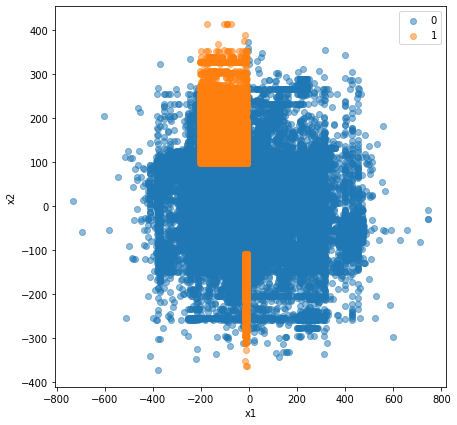

In [9]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### Tree with Depth 3

In [10]:
%%time
train_surrogate_tree(explanation, max_depth=3)

CPU times: user 29.4 ms, sys: 4.4 ms, total: 33.8 ms
Wall time: 38.1 ms


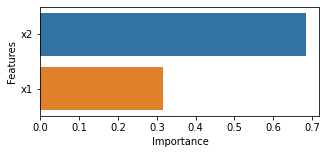

In [11]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

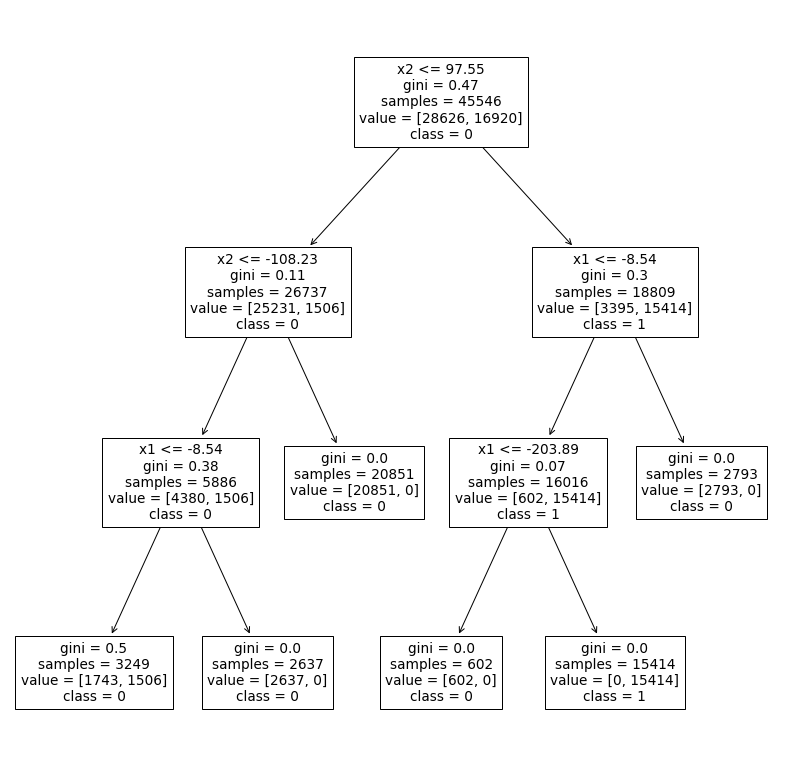

In [12]:
plot_surrogate_tree(explanation, precision=2)

In [14]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. -203.8949737548828 < x1 <= -8.543904304504395 and x2 > 97.55422973632812 [0, 15414]


In [15]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

33     1
60     1
68     1
97     1
117    1
143    1
154    1
171    1
181    1
183    1
211    1
233    1
245    1
270    1
281    1
285    1
289    1
dtype: int64

In [16]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28626
           1       1.00      0.91      0.95     16920

    accuracy                           0.97     45546
   macro avg       0.98      0.96      0.96     45546
weighted avg       0.97      0.97      0.97     45546



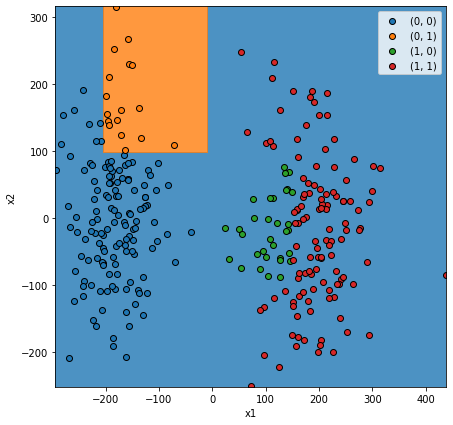

In [17]:
plot_tree_leafs_2d(explanation, comparer, X)

### Tree with Depth 4

In [18]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 28.6 ms, sys: 17.3 ms, total: 45.9 ms
Wall time: 50.7 ms


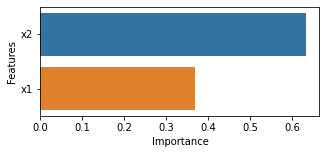

In [19]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

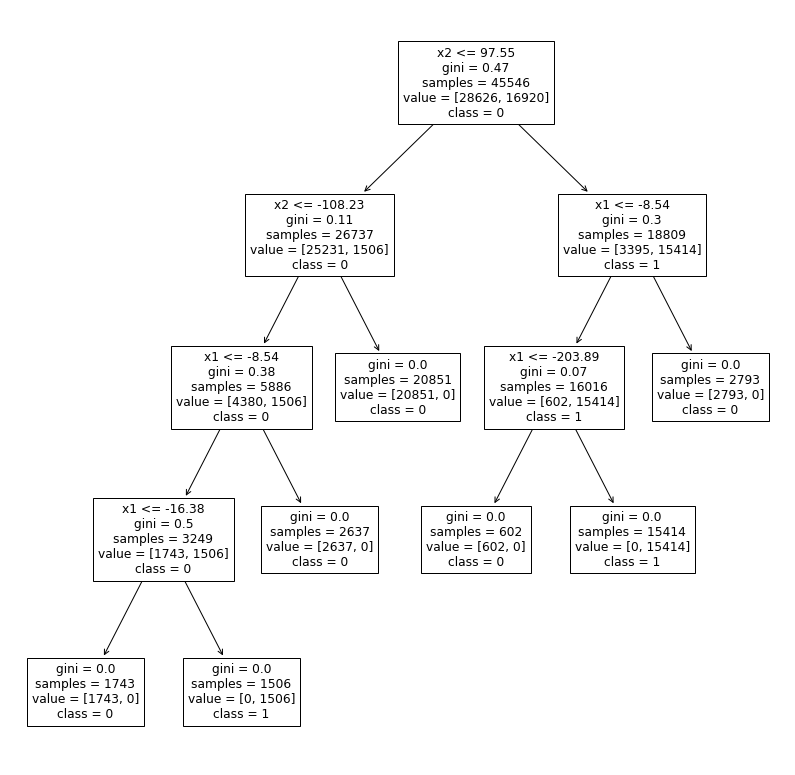

In [20]:
plot_surrogate_tree(explanation, precision=2)

In [21]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. -203.8949737548828 < x1 <= -8.543904304504395 and x2 > 97.55422973632812 [0, 15414]
2. -16.380329132080078 < x1 <= -8.543904304504395 and x2 <= -108.22959899902344 [0, 1506]


In [23]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)

33     1
60     1
68     1
97     1
117    1
143    1
154    1
171    1
181    1
183    1
211    1
233    1
245    1
270    1
281    1
285    1
289    1
dtype: int64

In [24]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28626
           1       1.00      1.00      1.00     16920

    accuracy                           1.00     45546
   macro avg       1.00      1.00      1.00     45546
weighted avg       1.00      1.00      1.00     45546



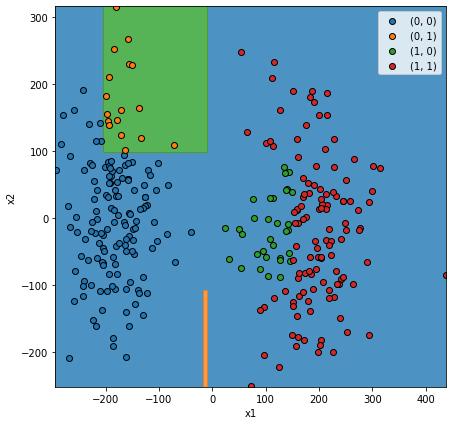

In [25]:
plot_tree_leafs_2d(explanation, comparer, X)

### Evaluation

#### Global Fidelity

In [26]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00        17

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



#### Counterfactual Fidelity Error

In [28]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [29]:
rmse

x1    0.077996
x2    0.054230
dtype: float64

In [30]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [31]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Complexity

In [32]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 6 (3.0 per rule)


#### Complexity

Complexity is evaluated without the rule for bonus task:

In [35]:
print_complexity(constraints[:1])

Number of rules: 1
Number of constraints: 3 (3.0 per rule)


#### Novelty

In [33]:
X_test = np.array([[-15, -110]])

In [34]:
rclf = RuleClassifier(feature_names, rules)
rclf.predict(X_test)

array([ True])

## $(1,0)$

In [36]:
focus_class = '(1, 0)'
focus_class_idx = list(comparer.class_names).index(focus_class)

In [10]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation(gn_population_size=5000)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanation), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 16min 8s, sys: 9.99 s, total: 16min 18s
Wall time: 17min 59s


In [37]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanation = pickle.load(f)

In [38]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

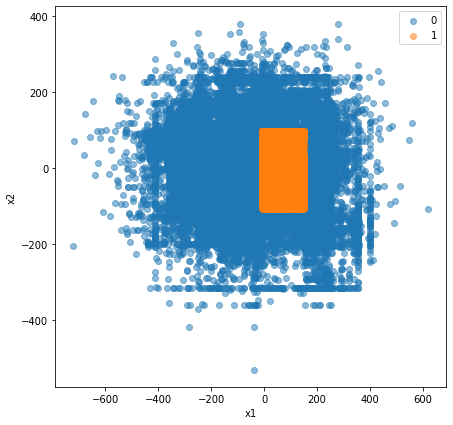

In [39]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### Tree with Depth 3

In [40]:
%%time
train_surrogate_tree(explanation, max_depth=3)

CPU times: user 33 ms, sys: 3.38 ms, total: 36.4 ms
Wall time: 38.6 ms


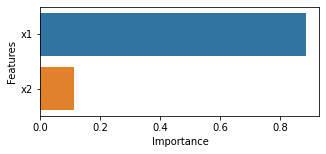

In [41]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

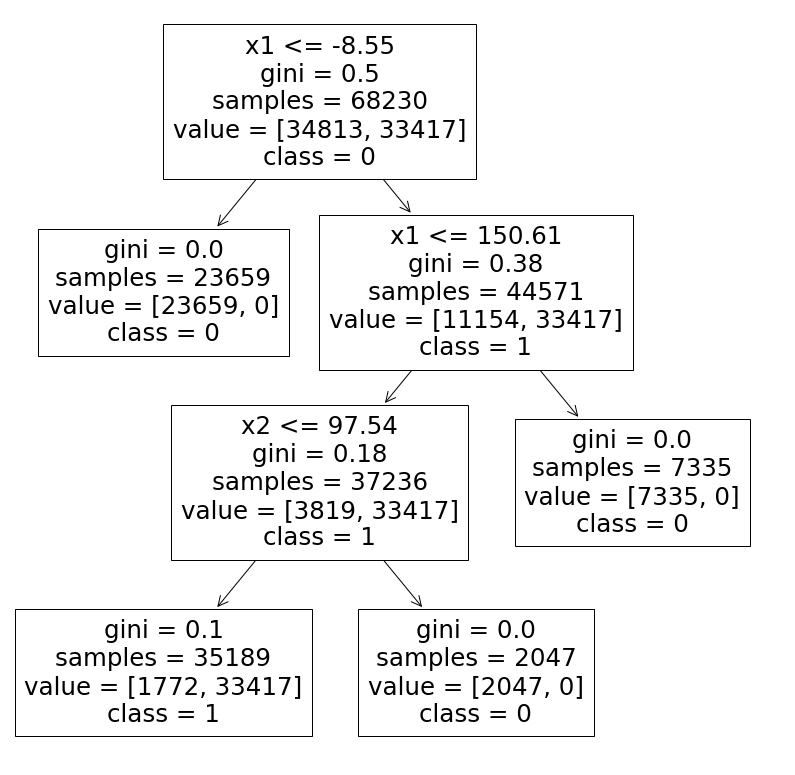

In [42]:
plot_surrogate_tree(explanation, precision=2)

In [43]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. -8.552433490753174 < x1 <= 150.6126937866211 and x2 <= 97.53524780273438 [1772, 33417]


In [44]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

3      1
17     1
21     1
49     1
76     1
80     1
110    1
119    1
125    1
135    1
139    1
140    1
142    1
147    1
159    1
161    1
168    1
174    1
175    1
193    1
199    1
209    1
230    1
235    1
240    1
241    1
250    1
254    1
258    1
273    1
278    1
279    1
dtype: int64

In [45]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     34813
           1       0.95      1.00      0.97     33417

    accuracy                           0.97     68230
   macro avg       0.97      0.97      0.97     68230
weighted avg       0.98      0.97      0.97     68230



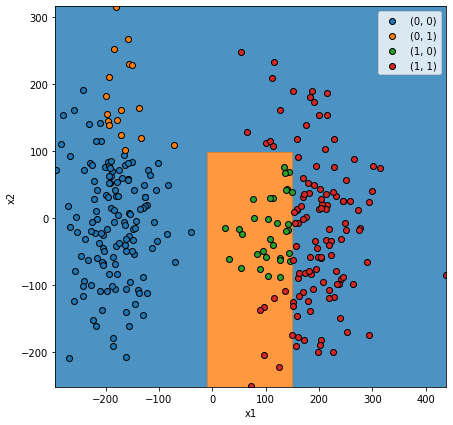

In [46]:
plot_tree_leafs_2d(explanation, comparer, X)

### Tree with Depth 4

In [47]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 42.5 ms, sys: 16.7 ms, total: 59.2 ms
Wall time: 63.2 ms


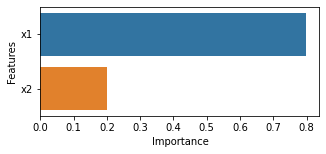

In [48]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order)

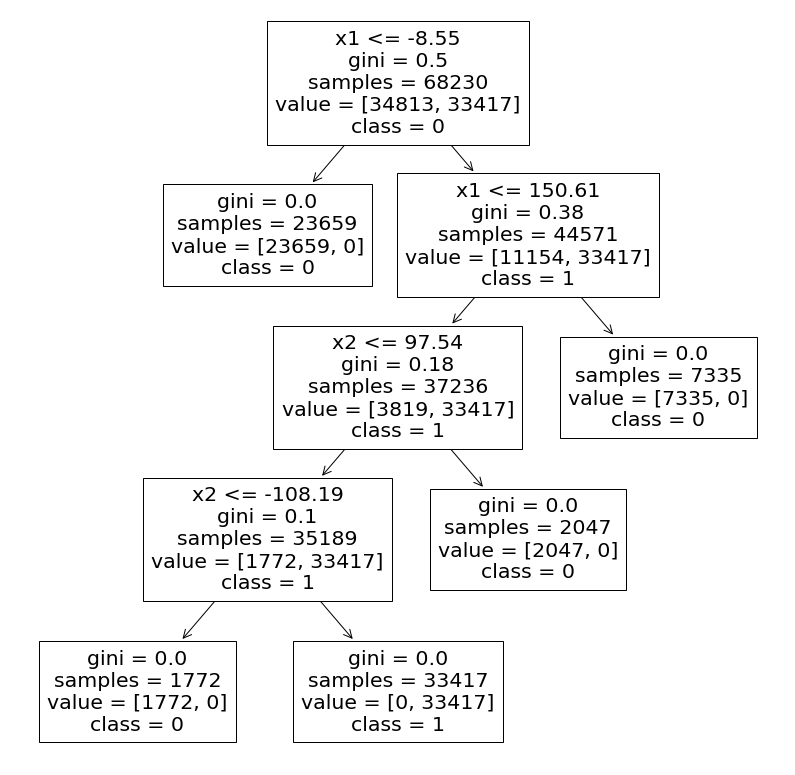

In [49]:
plot_surrogate_tree(explanation, precision=2)

In [50]:
y = (mclass_diff == focus_class_idx).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
print_rules(rules, class_occurences)

1. -8.552433490753174 < x1 <= 150.6126937866211 and -108.18930435180664 < x2 <= 97.53524780273438 [0, 33417]


In [51]:
indices = np.where(mclass_diff == focus_class_idx)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

3      1
17     1
21     1
49     1
76     1
80     1
110    1
119    1
125    1
135    1
139    1
140    1
142    1
147    1
159    1
161    1
168    1
174    1
175    1
193    1
199    1
209    1
230    1
235    1
240    1
241    1
250    1
254    1
258    1
273    1
278    1
279    1
dtype: int64

In [52]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34813
           1       1.00      1.00      1.00     33417

    accuracy                           1.00     68230
   macro avg       1.00      1.00      1.00     68230
weighted avg       1.00      1.00      1.00     68230



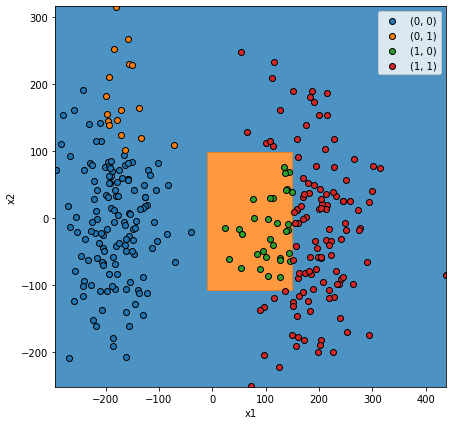

In [53]:
plot_tree_leafs_2d(explanation, comparer, X)

### Evaluation

#### Global Fidelity

In [54]:
evaluate(explanation, X, mclass_diff == focus_class_idx)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00        32

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



#### Counterfactual Fidelity Error

In [55]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [56]:
rmse

x1    0.070303
x2    0.026046
dtype: float64

In [57]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [58]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

##### Complexity

In [59]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 4 (4.0 per rule)


# Summary

## Global Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01 | 1.0 | 1.0 | 1.0
10 | 1.0 | 1.0 | 1.0

## Counterfactual Fidelity Error

Ruleset | RMSE | boundaries missed | unnecessary boundaries
 --- | --- | --- | ---
01 | <0.1 | 0% | 0%
10 | <0.1 | 0% | 0%

## Complexity

Ruleset | # Rules | # Constraints
 --- | --- | ---
01 | 1 | 3
10 | 1 | 4

Selectiveness: optimal

## Bonus Task

Correctly classified outlier.

## Generation Time

approx. 37min